In [1]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np

In [2]:
save_dir_path = "./save_directory_2" 


In [22]:
def visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=5, right_plot_alpha=0.3, verbose=False, specific_epoch='last'):
    """
    Visualizes how X_mean/U_mean evolve (left plot) and how X_std/U_std change (right plot)
    using ellipses at the same coordinates to represent standard deviation magnitudes.
    
    Args:
        save_dir_path: Path to the directory containing epoch folders
        number_of_points_to_plot: Number of trajectory IDs to randomly select
        right_plot_alpha: Transparency level for ellipses in right plots (0.0 to 1.0)
        verbose: If True, print trajectory values for a specific epoch
        specific_epoch: Either an integer epoch number or 'last' for the last epoch
    """

    traj_dirs = [
        "val_trajectories_data",
        "val_train_set_trajectories_data",
        "val_high_energy_trajectories_data"
    ]

    epoch_dirs = sorted(
        [d for d in os.listdir(save_dir_path) if d.startswith("epoch_")],
        key=lambda x: int(x.split("_")[1])
    )
    num_epochs = len(epoch_dirs)
    if num_epochs == 0:
        print("❌ No epoch directories found.")
        return

    # Color palette for epochs (left plots)
    epoch_cmap = cm.get_cmap("viridis")
    epoch_colors = [epoch_cmap(i / (num_epochs - 1)) for i in range(num_epochs)]
    
    # Color palette for trajectory IDs (right plots) - completely different
    traj_id_cmap = cm.get_cmap("Set3")

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for row_idx, traj_dir in enumerate(traj_dirs):
        print(f"\n📊 Processing directory: {traj_dir}")

        first_epoch_path = os.path.join(save_dir_path, epoch_dirs[0], traj_dir)
        if not os.path.exists(first_epoch_path):
            print(f"⚠️ Directory {first_epoch_path} not found. Skipping.")
            continue

        all_files = [f for f in os.listdir(first_epoch_path) if f.startswith("trajectory_id_") and f.endswith(".json")]
        if not all_files:
            print(f"⚠️ No trajectory files found in {first_epoch_path}.")
            continue

        trajectory_ids = [int(f.split("_")[2]) for f in all_files]
        random.seed(42)
        selected_ids = random.sample(trajectory_ids, min(number_of_points_to_plot, len(trajectory_ids)))

        # Create color map for trajectory IDs (right plots)
        traj_colors = {tid: traj_id_cmap(i / max(len(selected_ids) - 1, 1)) for i, tid in enumerate(selected_ids)}

        traj_data = {
            tid: {"X_mean": [], "U_mean": [], "X_std": [], "U_std": []}
            for tid in selected_ids
        }

        for epoch_dir in epoch_dirs:
            epoch_path = os.path.join(save_dir_path, epoch_dir, traj_dir)
            for tid in selected_ids:
                file_path = os.path.join(epoch_path, f"trajectory_id_{tid}_data.json")
                if not os.path.exists(file_path):
                    continue
                with open(file_path, "r") as f:
                    data = json.load(f)
                traj_data[tid]["X_mean"].append(data["X_mean"])
                traj_data[tid]["U_mean"].append(data["U_mean"])
                traj_data[tid]["X_std"].append(data["X_std"])
                traj_data[tid]["U_std"].append(data["U_std"])

        # --- Left plot: Means ---
        ax_mean = axes[row_idx, 0]
        ax_mean.set_title(f"{traj_dir.replace('_', ' ')} - Mean Evolution")
        ax_mean.set_xlabel("X_mean")
        ax_mean.set_ylabel("U_mean")
        ax_mean.grid(True, linestyle="--", alpha=0.5)

        for tid in selected_ids:
            Xs = traj_data[tid]["X_mean"]
            Us = traj_data[tid]["U_mean"]
            if len(Xs) < 2:
                continue
            for j in range(len(Xs) - 1):
                ax_mean.plot([Xs[j], Xs[j+1]], [Us[j], Us[j+1]], color=epoch_colors[j], alpha=0.8, linewidth=2)
            ax_mean.scatter(Xs[0], Us[0], color="red", marker="o", s=40)
            ax_mean.scatter(Xs[-1], Us[-1], color="black", marker="x", s=40)
        
        # Highlight specific_epoch if requested
        if specific_epoch is not None:
            # Determine which epoch index to mark
            if specific_epoch == 'last':
                epoch_idx = len(epoch_dirs) - 1
            else:
                # Find the epoch directory matching the specific_epoch number
                epoch_name = f"epoch_{specific_epoch}"
                if epoch_name in epoch_dirs:
                    epoch_idx = epoch_dirs.index(epoch_name)
                else:
                    epoch_idx = None
            
            if epoch_idx is not None:
                for tid in selected_ids:
                    Xs = traj_data[tid]["X_mean"]
                    Us = traj_data[tid]["U_mean"]
                    if epoch_idx < len(Xs):
                        ax_mean.scatter(
                            Xs[epoch_idx],
                            Us[epoch_idx],
                            color='lime',
                            marker='*',
                            s=300,
                            edgecolor='darkgreen',
                            linewidth=2,
                            zorder=10
                        )

        # --- Right plot: Std Ellipses ---
        ax_std = axes[row_idx, 1]
        ax_std.set_title(f"{traj_dir.replace('_', ' ')} - Std Ellipses")
        ax_std.set_xlabel("X_mean")
        ax_std.set_ylabel("U_mean")
        ax_std.grid(True, linestyle="--", alpha=0.5)

        for tid in selected_ids:
            Xs = traj_data[tid]["X_mean"]
            Us = traj_data[tid]["U_mean"]
            Xstds = traj_data[tid]["X_std"]
            Ustds = traj_data[tid]["U_std"]
            
            color = traj_colors[tid]

            for j in range(len(Xs)):
                e = Ellipse(
                    (Xs[j], Us[j]),
                    width=Xstds[j] * 2,  # scale factor for visibility
                    height=Ustds[j] * 2,
                    facecolor=color,
                    edgecolor="black",
                    alpha=right_plot_alpha
                )
                ax_std.add_patch(e)
            # Optional connecting path
            ax_std.plot(Xs, Us, color=color, alpha=right_plot_alpha, linewidth=1, label=f"Traj {tid}")
        
        # Highlight specific_epoch if requested
        if specific_epoch is not None:
            # Determine which epoch index to mark
            if specific_epoch == 'last':
                epoch_idx = len(epoch_dirs) - 1
            else:
                # Find the epoch directory matching the specific_epoch number
                epoch_name = f"epoch_{specific_epoch}"
                if epoch_name in epoch_dirs:
                    epoch_idx = epoch_dirs.index(epoch_name)
                else:
                    epoch_idx = None
            
            if epoch_idx is not None:
                for tid in selected_ids:
                    Xs = traj_data[tid]["X_mean"]
                    Us = traj_data[tid]["U_mean"]
                    if epoch_idx < len(Xs):
                        ax_std.scatter(
                            Xs[epoch_idx],
                            Us[epoch_idx],
                            color='lime',
                            marker='*',
                            s=300,
                            edgecolor='darkgreen',
                            linewidth=2,
                            zorder=10
                        )
        
        # Add legend for trajectory IDs
        ax_std.legend(loc="best", fontsize=8, framealpha=0.7)

        # Add colorbar for epoch progression on left plots
        norm = plt.Normalize(vmin=0, vmax=num_epochs - 1)
        sm = plt.cm.ScalarMappable(cmap=epoch_cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axes[row_idx, 0], orientation="horizontal", fraction=0.05, pad=0.1)
        cbar.set_label("Epoch progression")

        # Verbose output for specific epoch
        if verbose:
            # Determine which epoch index to use
            if specific_epoch == 'last':
                epoch_idx = len(epoch_dirs) - 1
                epoch_name = epoch_dirs[epoch_idx]
            else:
                # Find the epoch directory matching the specific_epoch number
                epoch_name = f"epoch_{specific_epoch}"
                if epoch_name in epoch_dirs:
                    epoch_idx = epoch_dirs.index(epoch_name)
                else:
                    print(f"⚠️ Epoch {specific_epoch} not found in {traj_dir}. Skipping verbose output.")
                    epoch_idx = None
            
            if epoch_idx is not None:
                print(f"\nFor the {epoch_name} in {traj_dir} the values are:")
                for tid in selected_ids:
                    if epoch_idx < len(traj_data[tid]["X_mean"]):
                        X_mean = traj_data[tid]["X_mean"][epoch_idx]
                        X_std = traj_data[tid]["X_std"][epoch_idx]
                        U_mean = traj_data[tid]["U_mean"][epoch_idx]
                        U_std = traj_data[tid]["U_std"][epoch_idx]
                        print(f"{tid}: {X_mean:.4f} ± {X_std:.4f}, {U_mean:.4f} ± {U_std:.4f}")
                    else:
                        print(f"{tid}: No data available")

    plt.tight_layout()
    plt.show()

In [23]:

def visualize_epoch_metrics(save_dir_path, metrics_to_plot, plot_on_same_graph=False, verbose=False):
    """
    Visualizes selected metrics from epoch directories.

    Args:
        save_dir_path (str): Path to the main directory containing 'epoch_n' subdirectories.
        metrics_to_plot (list of str): List of metric names to visualize.
        plot_on_same_graph (bool): If True, group related metrics (train/val variants) on the same plot.
        verbose (bool): If True, prints summary statistics for each metric.
    """

    # --- Collect all epoch directories ---
    epoch_dirs = sorted(
        [d for d in os.listdir(save_dir_path) if d.startswith("epoch_")],
        key=lambda x: int(x.split("_")[1])
    )

    # --- Collect data ---
    metrics_data = {metric: [] for metric in metrics_to_plot}
    epochs = []

    for d in epoch_dirs:
        epoch_path = os.path.join(save_dir_path, d, "epoch_metrics.json")
        if not os.path.isfile(epoch_path):
            print(f"⚠️ Skipping {d} (no epoch_metrics.json found)")
            continue

        with open(epoch_path, "r") as f:
            data = json.load(f)

        epoch_num = data.get("epoch", int(d.split("_")[1]))
        epochs.append(epoch_num)

        for metric in metrics_to_plot:
            metrics_data[metric].append(data.get(metric, None))

    # --- Verbose logging of statistics ---
    if verbose:
        print("\n📊 Metric summaries:")
        for metric in metrics_to_plot:
            values = [v for v in metrics_data[metric] if v is not None]
            if not values:
                print(f"  ⚠️ Metric {metric} has no valid values.")
                continue

            min_val = min(values)
            min_epoch = epochs[metrics_data[metric].index(min_val)]
            last_5 = values[-5:] if len(values) >= 5 else values
            print(
                f"  Lowest loss of metric '{metric}' recorded in epoch {min_epoch} "
                f"with the value: {min_val:.6f}, "
                f"the losses of the last 5 epochs are: {last_5}"
            )

    # --- Color scheme for each data source ---
    data_colors = {
        "train": "tab:blue",
        "val": "tab:orange",
        "val_high_energy": "tab:green",
        "val_training_set": "tab:red",
        "other": "tab:gray"
    }

    # --- Helper: identify data prefix and core metric ---
    def split_metric_name(metric):
        """
        Returns (data_prefix, core_metric)
        Handles trailing underscores and variants like _high_energy / _training_set.
        """
        m = metric.rstrip("_")  # remove trailing underscores

        prefix = "other"
        core = m

        if m.startswith("train_"):
            prefix = "train"
            core = m[len("train_"):]
        elif m.startswith("val_"):
            core = m[len("val_"):]
            if "_high_energy" in core:
                prefix = "val_high_energy"
                core = core.replace("_high_energy", "")
            elif "_training_set" in core:
                prefix = "val_training_set"
                core = core.replace("_training_set", "")
            else:
                prefix = "val"

        core = core.rstrip("_")
        return prefix, core

    # --- Plotting ---
    if plot_on_same_graph:
        # Group metrics by core metric name
        grouped = {}
        for metric in metrics_to_plot:
            prefix, core = split_metric_name(metric)
            grouped.setdefault(core, {})[prefix] = metric

        for core_metric, variants in grouped.items():
            plt.figure(figsize=(8, 5))
            for prefix, metric in variants.items():
                plt.plot(
                    epochs,
                    metrics_data[metric],
                    marker='o',
                    label=metric,
                    color=data_colors.get(prefix, None)
                )

            plt.title(f"{core_metric.replace('_', ' ').title()} across datasets")
            plt.xlabel("Epoch")
            plt.ylabel(core_metric)
            plt.grid(True, linestyle="--", alpha=0.6)
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        for metric in metrics_to_plot:
            prefix, _ = split_metric_name(metric)
            plt.figure(figsize=(8, 5))
            plt.plot(
                epochs,
                metrics_data[metric],
                marker='o',
                label=metric,
                color=data_colors.get(prefix, None)
            )
            plt.title(f"{metric.replace('_', ' ').title()} over epochs")
            plt.xlabel("Epoch")
            plt.ylabel(metric)
            plt.grid(True, linestyle="--", alpha=0.6)
            plt.legend()
            plt.tight_layout()
            plt.show()

    print("\n✅ Visualization complete.")



In [24]:
def analyze_folders_means(save_dir_path, locate_epoch=None):
    """
    Analyzes the mean and standard deviation of X_mean and U_mean across all trajectory IDs
    for each epoch and trajectory directory.
    
    Creates 3 plots showing how X_std_full and U_std_full evolve over epochs.
    
    Args:
        save_dir_path: Path to the directory containing epoch folders
        locate_epoch: If provided (integer), highlights this epoch in plots and prints its statistics
    """
    
    traj_dirs = [
        "val_trajectories_data",
        "val_train_set_trajectories_data",
        "val_high_energy_trajectories_data"
    ]
    
    epoch_dirs = sorted(
        [d for d in os.listdir(save_dir_path) if d.startswith("epoch_")],
        key=lambda x: int(x.split("_")[1])
    )
    num_epochs = len(epoch_dirs)
    if num_epochs == 0:
        print("❌ No epoch directories found.")
        return
    
    print(f"📊 Analyzing {num_epochs} epochs across {len(traj_dirs)} directories...")
    
    # Color map for epoch progression
    cmap = cm.get_cmap("plasma")
    colors = [cmap(i / (num_epochs - 1)) for i in range(num_epochs)]
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
    fig.suptitle("Evolution of Statistics Across Epochs", fontsize=16, fontweight='bold')
    fig.subplots_adjust(hspace=0.35, wspace=0.3)
    
    # Store data for all directories (for locate_epoch functionality)
    all_data = {}
    
    for row_idx, traj_dir in enumerate(traj_dirs):
        print(f"\n📁 Processing directory: {traj_dir}")
        
        # Storage for aggregated statistics per epoch
        X_mean_full_per_epoch = []
        X_std_full_per_epoch = []
        U_mean_full_per_epoch = []
        U_std_full_per_epoch = []
        
        for epoch_idx, epoch_dir in enumerate(epoch_dirs):
            epoch_path = os.path.join(save_dir_path, epoch_dir, traj_dir)
            
            if not os.path.exists(epoch_path):
                print(f"⚠️ Directory {epoch_path} not found. Skipping epoch.")
                X_mean_full_per_epoch.append(np.nan)
                X_std_full_per_epoch.append(np.nan)
                U_mean_full_per_epoch.append(np.nan)
                U_std_full_per_epoch.append(np.nan)
                continue
            
            # Get all trajectory files in this epoch
            all_files = [f for f in os.listdir(epoch_path) if f.startswith("trajectory_id_") and f.endswith(".json")]
            
            if not all_files:
                print(f"⚠️ No trajectory files found in {epoch_path}.")
                X_mean_full_per_epoch.append(np.nan)
                X_std_full_per_epoch.append(np.nan)
                U_mean_full_per_epoch.append(np.nan)
                U_std_full_per_epoch.append(np.nan)
                continue
            
            # Collect X_mean and U_mean from all trajectories
            X_means = []
            U_means = []
            
            for file_name in all_files:
                file_path = os.path.join(epoch_path, file_name)
                with open(file_path, "r") as f:
                    data = json.load(f)
                    X_means.append(data["X_mean"])
                    U_means.append(data["U_mean"])
            
            # Calculate means and standard deviations across all trajectory IDs
            X_mean_full = np.mean(X_means)
            X_std_full = np.std(X_means)
            U_mean_full = np.mean(U_means)
            U_std_full = np.std(U_means)
            
            X_mean_full_per_epoch.append(X_mean_full)
            X_std_full_per_epoch.append(X_std_full)
            U_mean_full_per_epoch.append(U_mean_full)
            U_std_full_per_epoch.append(U_std_full)
        
        # Store data for this directory
        all_data[traj_dir] = {
            'X_mean_full': X_mean_full_per_epoch,
            'X_std_full': X_std_full_per_epoch,
            'U_mean_full': U_mean_full_per_epoch,
            'U_std_full': U_std_full_per_epoch
        }
        
        # ===== LEFT PLOT: Standard Deviations =====
        ax_std = axes[row_idx, 0]
        ax_std.set_title(f"{traj_dir.replace('_', ' ')} - Std Deviation")
        ax_std.set_xlabel("X_std_full (Std of X_means)")
        ax_std.set_ylabel("U_std_full (Std of U_means)")
        ax_std.grid(True, linestyle="--", alpha=0.5)
        
        # Plot lines connecting epochs
        for i in range(len(X_std_full_per_epoch) - 1):
            if not (np.isnan(X_std_full_per_epoch[i]) or np.isnan(X_std_full_per_epoch[i+1])):
                ax_std.plot(
                    [X_std_full_per_epoch[i], X_std_full_per_epoch[i+1]],
                    [U_std_full_per_epoch[i], U_std_full_per_epoch[i+1]],
                    color=colors[i],
                    alpha=0.8,
                    linewidth=2
                )
        
        # Plot points for each epoch
        valid_indices = [i for i in range(len(X_std_full_per_epoch)) if not np.isnan(X_std_full_per_epoch[i])]
        for i in valid_indices:
            ax_std.scatter(
                X_std_full_per_epoch[i],
                U_std_full_per_epoch[i],
                color=colors[i],
                s=100,
                edgecolor='black',
                linewidth=1.5,
                zorder=5
            )
        
        # Mark start and end
        if valid_indices:
            ax_std.scatter(
                X_std_full_per_epoch[valid_indices[0]],
                U_std_full_per_epoch[valid_indices[0]],
                color='red',
                marker='o',
                s=150,
                edgecolor='black',
                linewidth=2,
                zorder=6,
                label='Start'
            )
            ax_std.scatter(
                X_std_full_per_epoch[valid_indices[-1]],
                U_std_full_per_epoch[valid_indices[-1]],
                color='black',
                marker='x',
                s=150,
                linewidth=3,
                zorder=6,
                label='End'
            )
        
        # Highlight the specific epoch if requested
        if locate_epoch is not None and locate_epoch < len(X_std_full_per_epoch):
            if not np.isnan(X_std_full_per_epoch[locate_epoch]):
                ax_std.scatter(
                    X_std_full_per_epoch[locate_epoch],
                    U_std_full_per_epoch[locate_epoch],
                    color='lime',
                    marker='*',
                    s=400,
                    edgecolor='darkgreen',
                    linewidth=3,
                    zorder=7,
                    label=f'Epoch {locate_epoch}'
                )
        
        if valid_indices or locate_epoch is not None:
            ax_std.legend(loc='best')
        
        # Add colorbar for epoch progression
        norm = plt.Normalize(vmin=0, vmax=num_epochs - 1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar_std = fig.colorbar(sm, ax=ax_std, orientation="horizontal", fraction=0.05, pad=0.15)
        cbar_std.set_label("Epoch progression")
        
        # ===== RIGHT PLOT: Means =====
        ax_mean = axes[row_idx, 1]
        ax_mean.set_title(f"{traj_dir.replace('_', ' ')} - Mean Values")
        ax_mean.set_xlabel("X_mean_full (Mean of X_means)")
        ax_mean.set_ylabel("U_mean_full (Mean of U_means)")
        ax_mean.grid(True, linestyle="--", alpha=0.5)
        
        # Plot lines connecting epochs
        for i in range(len(X_mean_full_per_epoch) - 1):
            if not (np.isnan(X_mean_full_per_epoch[i]) or np.isnan(X_mean_full_per_epoch[i+1])):
                ax_mean.plot(
                    [X_mean_full_per_epoch[i], X_mean_full_per_epoch[i+1]],
                    [U_mean_full_per_epoch[i], U_mean_full_per_epoch[i+1]],
                    color=colors[i],
                    alpha=0.8,
                    linewidth=2
                )
        
        # Plot points for each epoch
        valid_indices_mean = [i for i in range(len(X_mean_full_per_epoch)) if not np.isnan(X_mean_full_per_epoch[i])]
        for i in valid_indices_mean:
            ax_mean.scatter(
                X_mean_full_per_epoch[i],
                U_mean_full_per_epoch[i],
                color=colors[i],
                s=100,
                edgecolor='black',
                linewidth=1.5,
                zorder=5
            )
        
        # Mark start and end
        if valid_indices_mean:
            ax_mean.scatter(
                X_mean_full_per_epoch[valid_indices_mean[0]],
                U_mean_full_per_epoch[valid_indices_mean[0]],
                color='red',
                marker='o',
                s=150,
                edgecolor='black',
                linewidth=2,
                zorder=6,
                label='Start'
            )
            ax_mean.scatter(
                X_mean_full_per_epoch[valid_indices_mean[-1]],
                U_mean_full_per_epoch[valid_indices_mean[-1]],
                color='black',
                marker='x',
                s=150,
                linewidth=3,
                zorder=6,
                label='End'
            )
        
        # Highlight the specific epoch if requested
        if locate_epoch is not None and locate_epoch < len(X_mean_full_per_epoch):
            if not np.isnan(X_mean_full_per_epoch[locate_epoch]):
                ax_mean.scatter(
                    X_mean_full_per_epoch[locate_epoch],
                    U_mean_full_per_epoch[locate_epoch],
                    color='lime',
                    marker='*',
                    s=400,
                    edgecolor='darkgreen',
                    linewidth=3,
                    zorder=7,
                    label=f'Epoch {locate_epoch}'
                )
        
        if valid_indices_mean or locate_epoch is not None:
            ax_mean.legend(loc='best')
        
        # Add colorbar for epoch progression
        cbar_mean = fig.colorbar(sm, ax=ax_mean, orientation="horizontal", fraction=0.05, pad=0.15)
        cbar_mean.set_label("Epoch progression")
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for the located epoch
    if locate_epoch is not None:
        print(f"\n{'='*60}")
        print(f"Statistics for Epoch {locate_epoch}:")
        print(f"{'='*60}")
        for traj_dir in traj_dirs:
            if locate_epoch < len(all_data[traj_dir]['X_mean_full']):
                X_mean_full = all_data[traj_dir]['X_mean_full'][locate_epoch]
                X_std_full = all_data[traj_dir]['X_std_full'][locate_epoch]
                U_mean_full = all_data[traj_dir]['U_mean_full'][locate_epoch]
                U_std_full = all_data[traj_dir]['U_std_full'][locate_epoch]
                
                if not np.isnan(X_mean_full):
                    print(f"\n{traj_dir}:")
                    print(f"  X: {X_mean_full:.6f} ± {X_std_full:.6f}")
                    print(f"  U: {U_mean_full:.6f} ± {U_std_full:.6f}")
                else:
                    print(f"\n{traj_dir}: No data available")
            else:
                print(f"\n{traj_dir}: Epoch {locate_epoch} not found")
        print(f"{'='*60}")
    


📊 Metric summaries:
  Lowest loss of metric 'train_prediction_loss_' recorded in epoch 152 with the value: 47.130005, the losses of the last 5 epochs are: [50.670461828058414, 50.981949437748305, 49.03972155397589, 67.92123139988293, 56.94584120403636]
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 169 with the value: 26.761174, the losses of the last 5 epochs are: [37.89809354146322, 26.76117428143819, 41.58318090438843, 35.78408241271973, 35.74609057108561]
  Lowest loss of metric 'val_prediction_loss_training_set' recorded in epoch 169 with the value: 35.658809, the losses of the last 5 epochs are: [47.397512217362724, 35.65880853931109, 47.646944016218185, 41.40273315707842, 43.8481460014979]
  Lowest loss of metric 'train_variance_loss_' recorded in epoch 152 with the value: 58.109463, the losses of the last 5 epochs are: [63.92128183624961, 63.33367861400951, 60.29795176332647, 84.4904006394473, 67.31720451875167]
  Lowest loss of metric 'val_variance_loss_' re

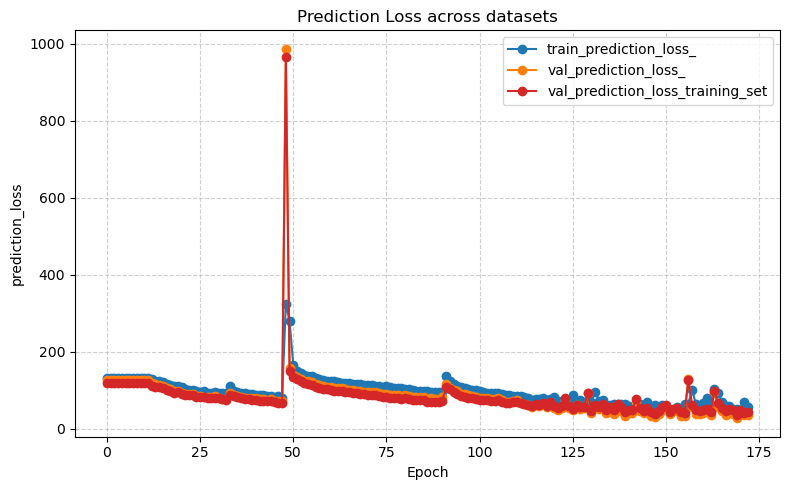

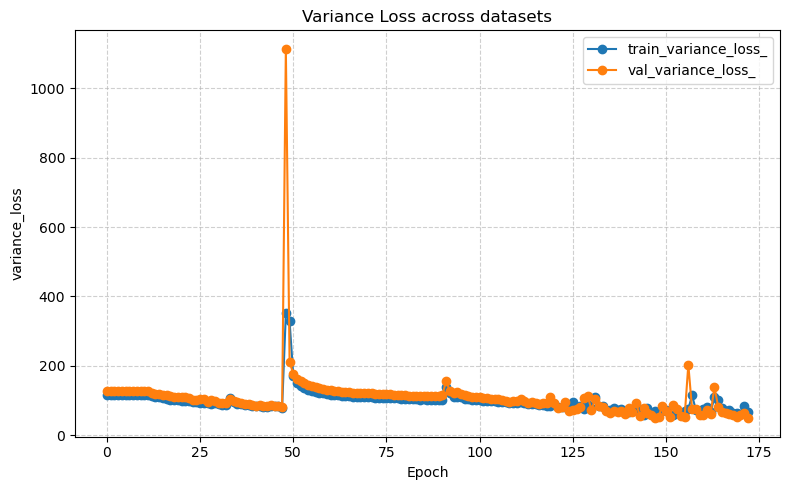

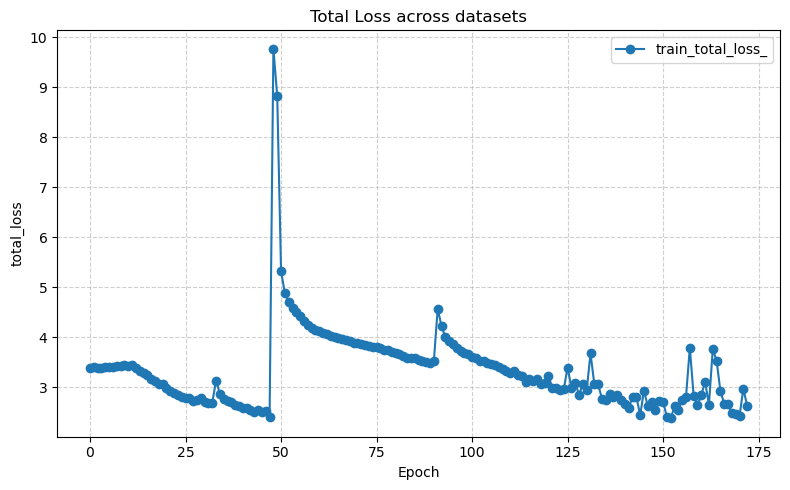

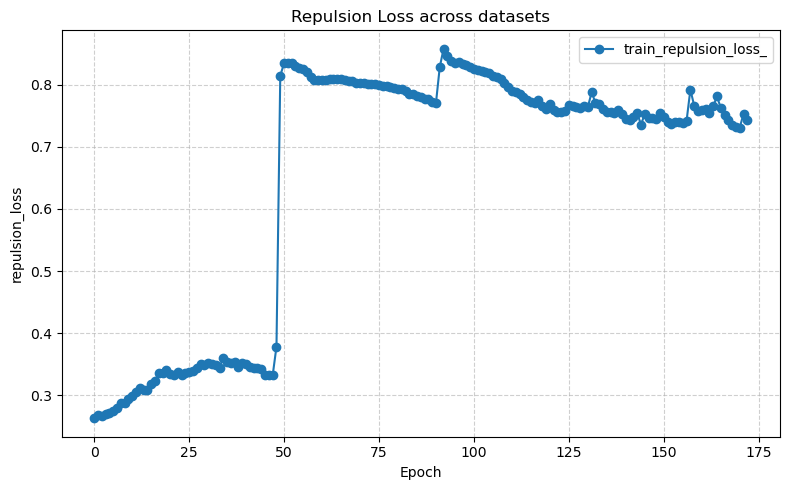

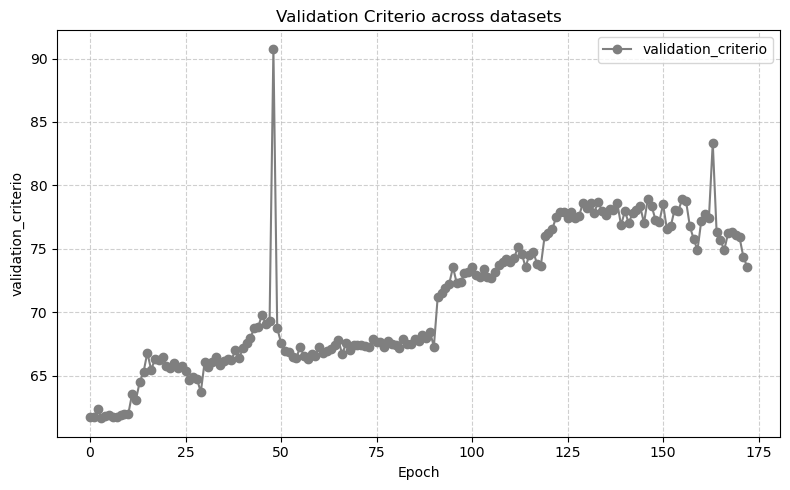


✅ Visualization complete.


In [118]:
visualize_epoch_metrics(
 save_dir_path,
["train_prediction_loss_", "val_prediction_loss_",'val_prediction_loss_training_set',  "train_variance_loss_", "val_variance_loss_", "train_total_loss_", "train_repulsion_loss_", "validation_criterio"],
plot_on_same_graph=True,
verbose=True
)



📊 Processing directory: val_trajectories_data


/tmp/ipykernel_7641/3868726573.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  epoch_cmap = cm.get_cmap("viridis")
/tmp/ipykernel_7641/3868726573.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  traj_id_cmap = cm.get_cmap("Set3")



For the epoch_172 in val_trajectories_data the values are:
92: 11.5865 ± 5.0866, -35.0444 ± 5.7226
64: 11.4423 ± 3.3530, -32.8017 ± 3.0000
6: 19.8188 ± 5.7905, -24.5588 ± 3.8071
71: 16.1462 ± 3.8407, -33.6544 ± 3.9500
50: 30.1904 ± 6.0669, -26.1749 ± 3.1780
103: 14.2480 ± 5.3707, -35.1613 ± 6.5351

📊 Processing directory: val_train_set_trajectories_data

For the epoch_172 in val_train_set_trajectories_data the values are:
2: 13.4213 ± 4.7653, -24.7050 ± 4.6431
120: 35.9520 ± 8.1061, -24.9172 ± 5.6549
96: 35.1416 ± 6.8857, -26.7433 ± 3.7012
69: 15.5708 ± 3.8209, -33.4326 ± 3.8319
8: 18.5619 ± 5.6539, -27.2783 ± 2.6342
98: 14.0682 ± 4.2801, -35.2874 ± 5.7037

📊 Processing directory: val_high_energy_trajectories_data

For the epoch_172 in val_high_energy_trajectories_data the values are:
9: 51.3985 ± 83.2607, -27.8904 ± 55.5072
13: 19.5021 ± 72.9954, 18.0707 ± 84.8416
18: 25.1284 ± 108.9506, -19.1379 ± 85.8000
19: 14.1494 ± 104.7507, 26.9578 ± 88.4725
4: 64.7260 ± 45.7636, 1.5017 ± 45.44

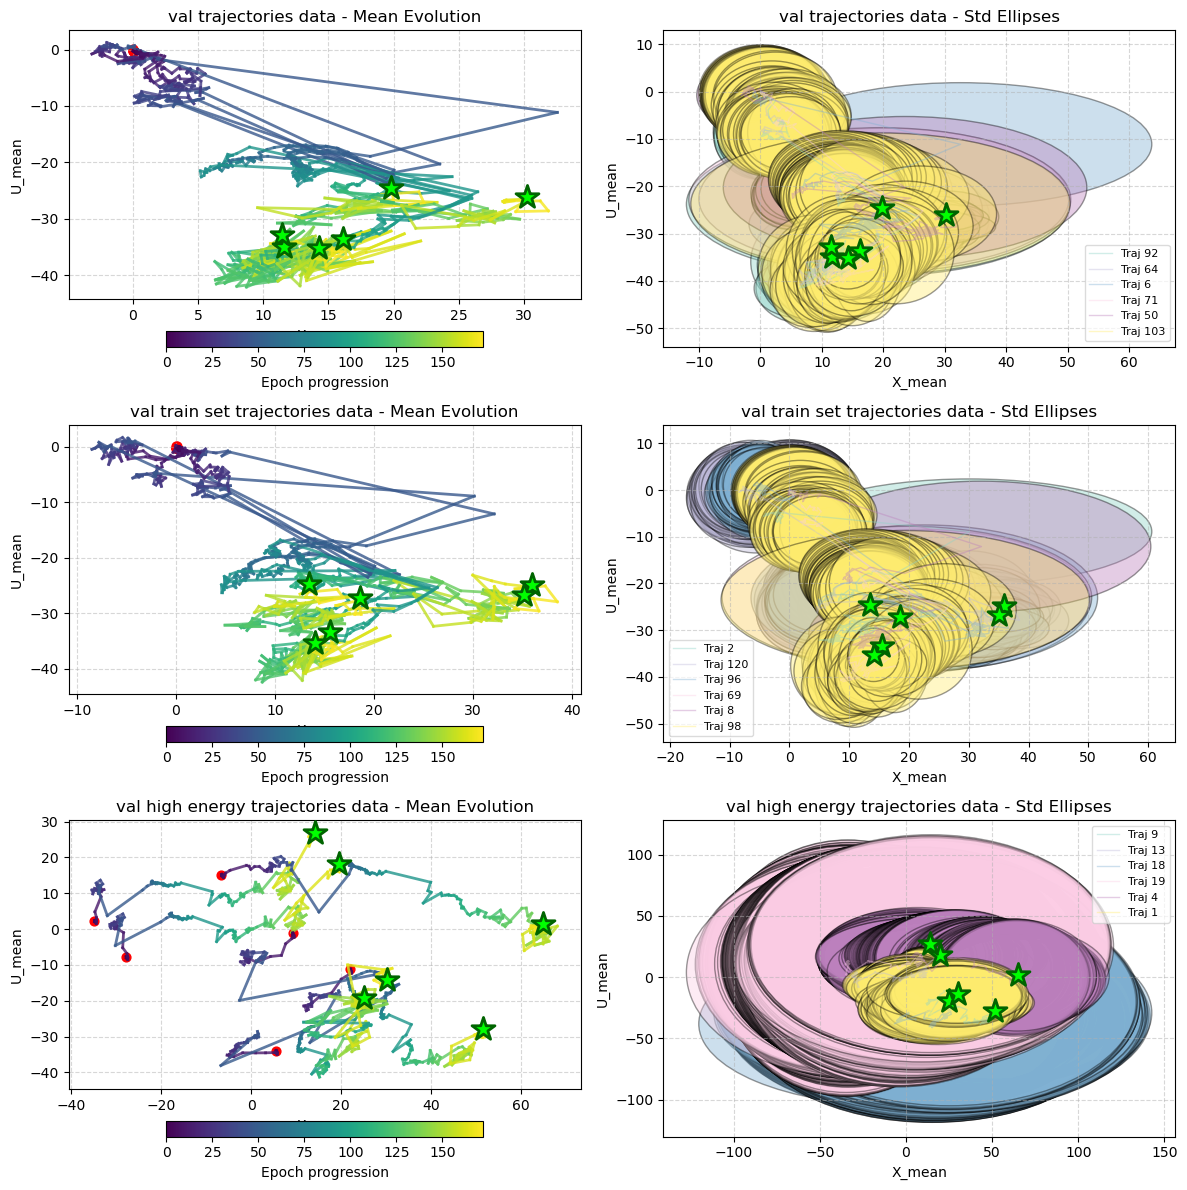

In [119]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=6, right_plot_alpha=0.4, verbose=True, specific_epoch='last')

📊 Analyzing 174 epochs across 3 directories...

📁 Processing directory: val_trajectories_data


/tmp/ipykernel_7641/952525528.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")



📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data


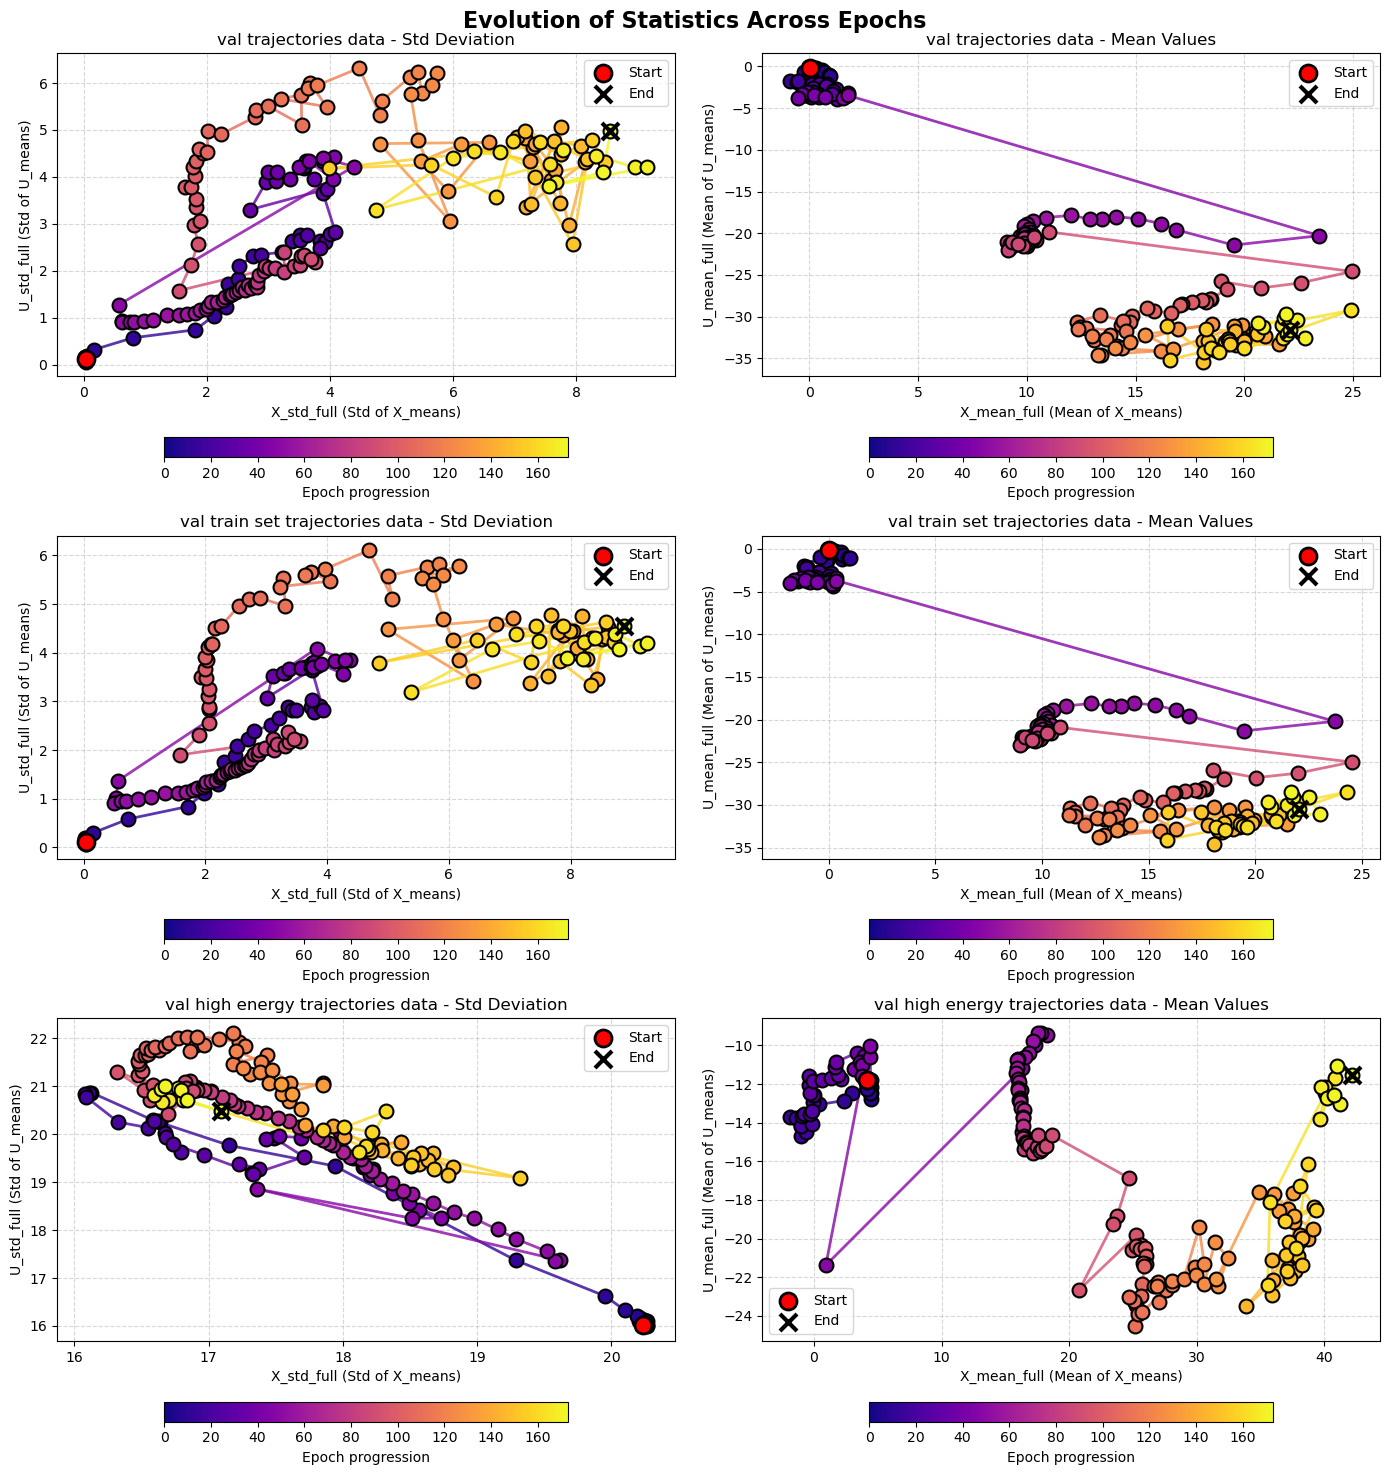

In [120]:
analyze_folders_means(save_dir_path, locate_epoch=None)